In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import DCM

In [7]:
df_psm = pd.read_stata('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing lottery (A) -> higher sure payoff
# 0 - choosing sure payoff (B) -> lower sure payoff
# j: layer / order of choice question
# i: node in the current layer

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_psm['v_110'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_psm['v_110'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_risk = pd.concat([df_psm, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_risk = df_risk.reset_index(names='pid')

q_columns = [col for col in df_risk.columns if 'layer_' in col]

df_melted = df_risk.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_risk', value_name='choice').dropna()

# Calculate the sure payoff for each question
def sure_pay(s):
    parts = s.strip().split('_')

    layer_number = j_max - int(parts[1]) + 1 
    q_number = int(parts[2][1:])

    return 2**(layer_number) + (q_number - 1)*2**(layer_number+1)

df_melted['x'] = df_melted['q_risk'].apply(sure_pay)*0.1
df_melted['layer'] = df_melted['q_risk'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_risk = pd.merge(right=df_risk[['pid','v_110']].dropna(),left=df_wide,on='pid')

In [8]:
def prop_test(tab_count):
    for i in range(1, 33):
        if str(i) not in tab_count.index:
            tab_count[str(i)] = 0

    tab_count.index = tab_count.index.astype(int)
    tab_count = tab_count.sort_index()

    result_prop_test = pd.DataFrame({})

    for i in range(4):

        new_table = [sum(tab_count[x:x + 2**i]) for x in range(0, len(tab_count), 2**i)]

        max_group = len(tab_count) // ((i + 1) * 4) - 1

        # Iterate over groups
        for g in range(int(max_group) + 1):
            # Select the current group of 4 elements
            node_count = new_table[4 * g:4 * g + 4]

            print(f"Testing layer {4 - i}, group {g + 1}")
            
            try:
                # Perform the prop test
                new_row = DCM.run_prop_test(node_count)
                
                # Add layer and group information
                new_row.update({"layer": 4 - i, "group": g + 1})
                
                # Append the result as a new row
                result_prop_test = pd.concat([result_prop_test, pd.DataFrame([new_row])], ignore_index=True)
            
            except Exception as e:
                print(f"Error: {e}")
                print(node_count)
    
    return result_prop_test

In [9]:
tab_count = df_psm['v_110'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

result_prop_test = prop_test(tab_count)
# prop_test_sort = sorted(result_prop_test[['p_lo_0','p_0_hi']].values.flatten(),reverse= True)
prop_test_sort = sorted(result_prop_test[['p_lo_hi']].values.flatten(),reverse= True)
min(np.array(prop_test_sort) * np.arange(1,len(prop_test_sort)+1))


Testing layer 4, group 1
Testing layer 4, group 2
Testing layer 4, group 3
Testing layer 4, group 4
Testing layer 4, group 5
Testing layer 4, group 6
Testing layer 4, group 7
Testing layer 4, group 8
Testing layer 3, group 1
Testing layer 3, group 2
Testing layer 3, group 3
Testing layer 3, group 4
Testing layer 2, group 1
Testing layer 2, group 2
Testing layer 1, group 1
Testing layer 1, group 2
Error: list index out of range
[]


0.14215381655752868

In [10]:
result_prop_test.to_csv('prop_result_risk.csv')
result_prop_test

,n,prop_lo,prop_0,prop_hi,p_lo_0,p_0_hi,p_lo_hi,p_up,layer,group
0,72,0.566667,0.583333,0.595238,0.523840,0.530150,0.499084,0.530150,4,1
1,87,0.465116,0.505747,0.454545,0.401686,0.769794,0.623165,0.769794,4,2
2,85,0.770833,0.435294,0.621622,0.999969,0.044732,0.958586,0.089464,4,3
3,69,0.480000,0.637681,0.181818,0.127735,1.000000,0.997971,0.255469,4,4
4,52,0.227273,0.576923,0.400000,0.005570,0.962218,0.155697,0.011140,4,5
5,9,1.000000,0.888889,0.375000,1.000000,0.997738,1.000000,1.000000,4,6
6,13,0.333333,0.538462,0.000000,0.369969,1.000000,1.000000,0.739938,4,7
7,7,0.200000,0.285714,1.000000,0.636364,0.166667,0.142857,0.333333,4,8
8,159,0.583333,0.547170,0.505747,0.743524,0.775296,0.872307,0.775296,3,1
9,154,0.435294,0.448052,0.637681,0.479048,0.006519,0.009477,0.013038,3,2


In [11]:
no_1 = result_prop_test['n']*result_prop_test['prop_0']*result_prop_test['prop_lo']
no_2 = result_prop_test['n']*result_prop_test['prop_0']*result_prop_test['prop_hi']
de_1 = no_1/result_prop_test['p_lo_0']
de_2 = no_2/result_prop_test['p_0_hi']

(sum(no_1) + sum(no_2)) / (sum(de_1) + sum(de_2))

0.001516280417111889

In [12]:
x1_cols = [col for col in df_risk.columns if 'layer_x' in col]
choice_cols = [col for col in df_risk.columns if 'layer_choice' in col]

model = DCM.mixedModel(data=df_risk,
                choice = choice_cols,
                x1 = 3,
                x2 = x1_cols,
                p1 = 0.5)


In [13]:
risk_init_list = [.1,.3,.5,.7]
temp_init_list = [.3,.4,.5]

for r in risk_init_list:
    for temp in temp_init_list:
        model.set_init_param(param_keys=['riskCoef','temp'],param_init=[r,temp])
        try:
            result_iid = model.fit_param(bounds=[(0,None),(0,None)])
            if not np.isnan(result_iid.fun):
                print(r,temp)
                print(result_iid.fun)
                print(result_iid.x)
        except Exception as e:
            print(f"Error: {e}")

0.1 0.3
200170.27809585052
[0.10447249 0.36213507]
0.3 0.3
200170.27809586623
[0.30528872 0.33663389]


e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:47: RuntimeWarning: divide by zero encountered in divide
  prob = 1/(1+ np.exp(-u_diff / params['temp']))
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:188: RuntimeWarning: divide by zero encountered in log
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:188: RuntimeWarning: invalid value encountered in multiply
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:47: RuntimeWarning: overflow encountered in exp
  prob = 1/(1+ np.exp(-u_diff / params['temp']))


In [14]:
model.set_init_mixed(latent_class= {'riskCoef':[0.1,0.3], 'temp':[.3,.3]}, latent_share= [1/2]*2)

In [15]:
model.runEM(bounds=[(0,None),(0,None)])

Iteration 1
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.653 102678.437]
Iteration 2
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.656 102678.434]
Iteration 3
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.653 102678.437]
Iteration 4
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.654 102678.436]
Iteration 5
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.654 102678.436]
Iteration 6
Class share [0.499 0.501]
Class parameter {'riskCoef': array([0.103, 0.307]), 'temp': array([0.347, 0.351])}
objective [ 97389.656 102678.434]
Iteration 7
Class share [0.499 0.501]
Class parameter {'riskCoef': arr

(array([ 81.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 313.]),
 array([0.4766532 , 0.47947064, 0.48228809, 0.48510553, 0.48792298,
        0.49074042, 0.49355786, 0.49637531, 0.49919275, 0.5020102 ,
        0.50482764]),
 <BarContainer object of 10 artists>)

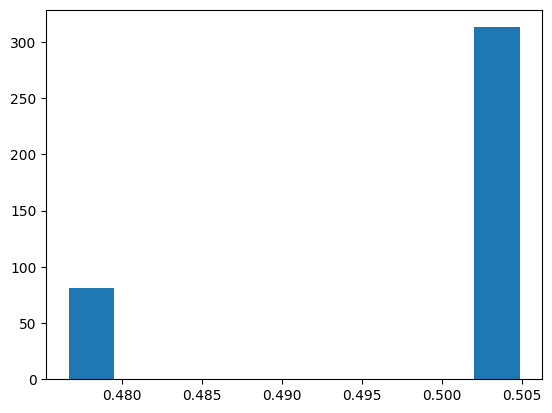

In [16]:
plt.hist(model.post_prob[:,0])


In [21]:
df_psm = pd.read_stata('../preference survey module/data/MainSample_Replication.dta')

# Recover answers to each question
# 1 - choosing SS (A) -> higher LL
# 0 - choosing LL (B) -> lower LL

df_psm['v_195'] = 32 - df_psm['v_195']

j_max = 4

for j in range(j_max+1):
    for i in range(2**(j_max-j)):

        col_name = 'layer_' + str(j_max-j+1) + '_q' +str(i+1)

        conditions = [
            df_psm['v_195'].between((2*i)*2**j+1, (2*i+1)*2**j),   
            df_psm['v_195'].between((2*i+1)*2**j+1, (2*i+2)*2**j) 
        ]

        choice_labels = [0, 1]

        new_col = np.select(conditions, choice_labels, default=np.nan)
        
        df_psm = pd.concat([df_psm, pd.DataFrame({col_name: new_col})], axis=1)

# Melt the data: each row represent a choice 
df_psm = df_psm.reset_index(names='pid')

q_columns = [col for col in df_psm.columns if 'layer_' in col]

df_melted = df_psm.melt(id_vars='pid', value_vars=q_columns, 
                        var_name='q_time', value_name='choice').dropna()

# Encode the LL payoff for each question
node_encoding_reverse = {
    (1, 1): 154,  # Layer 1 (Root), Node 1
    (2, 1): 125,  # Layer 2, Node 1 (Reversed)
    (2, 2): 185,  # Layer 2, Node 2 (Reversed)
    (3, 1): 112,  # Layer 3, Node 1 (Reversed)
    (3, 2): 139,  # Layer 3, Node 2 (Reversed)
    (3, 3): 169,  # Layer 3, Node 3 (Reversed)
    (3, 4): 202,  # Layer 3, Node 4 (Reversed)
    (4, 1): 106,  # Layer 4, Node 1 (Reversed)
    (4, 2): 119,  # Layer 4, Node 2 (Reversed)
    (4, 3): 132,  # Layer 4, Node 3 (Reversed)
    (4, 4): 146,  # Layer 4, Node 4 (Reversed)
    (4, 5): 161,  # Layer 4, Node 5 (Reversed)
    (4, 6): 177,  # Layer 4, Node 6 (Reversed)
    (4, 7): 193,  # Layer 4, Node 7 (Reversed)
    (4, 8): 210,  # Layer 4, Node 8 (Reversed)
    (5, 1): 103,  # Layer 5, Node 1 (Reversed)
    (5, 2): 109,  # Layer 5, Node 2 (Reversed)
    (5, 3): 116,  # Layer 5, Node 3 (Reversed)
    (5, 4): 129,  # Layer 5, Node 4 (Reversed)
    (5, 5): 122,  # Layer 5, Node 5 (Reversed)
    (5, 6): 136,  # Layer 5, Node 6 (Reversed)
    (5, 7): 143,  # Layer 5, Node 7 (Reversed)
    (5, 8): 150,  # Layer 5, Node 8 (Reversed)
    (5, 9): 158,  # Layer 5, Node 9 (Reversed)
    (5, 10): 165, # Layer 5, Node 10 (Reversed)
    (5, 11): 173, # Layer 5, Node 11 (Reversed)
    (5, 12): 181, # Layer 5, Node 12 (Reversed)
    (5, 13): 189, # Layer 5, Node 13 (Reversed)
    (5, 14): 197, # Layer 5, Node 14 (Reversed)
    (5, 15): 206, # Layer 5, Node 15 (Reversed)
    (5, 16): 215  # Layer 5, Node 16 (Reversed)
}

def LL_pay(s):
    parts = s.strip().split('_')

    layer_number = int(parts[1])
    q_number = int(parts[2][1:])

    return node_encoding_reverse.get((layer_number, q_number), "Node not found")


df_melted['x'] = df_melted['q_time'].apply(LL_pay)*0.01
df_melted['layer'] = df_melted['q_time'].apply(lambda x: x.strip().split('_')[1])

# Pivot the data
df_wide = df_melted[['pid','x','choice','layer']].pivot(index='pid', columns='layer', values=['x', 'choice'])

df_wide.columns = [f"layer_{col}_{layer}" for col, layer in df_wide.columns]
df_wide = df_wide.reset_index()

# Merge with the original levels
df_psm = pd.merge(right=df_psm[['pid','v_195']].dropna(),left=df_wide,on='pid')

In [22]:
tab_count = df_psm['v_195'].value_counts()
tab_count.index = tab_count.index.astype(int).astype(str)

result_prop_test = prop_test(tab_count)
# prop_test_sort = sorted(result_prop_test[['p_lo_0','p_0_hi']].values.flatten(),reverse= True)
prop_test_sort = sorted(result_prop_test[['p_lo_hi']].values.flatten(),reverse= True)
min(np.array(prop_test_sort) * np.arange(1,len(prop_test_sort)+1))

Testing layer 4, group 1
Testing layer 4, group 2
Testing layer 4, group 3
Testing layer 4, group 4
Testing layer 4, group 5
Testing layer 4, group 6
Testing layer 4, group 7
Testing layer 4, group 8
Testing layer 3, group 1
Testing layer 3, group 2
Testing layer 3, group 3
Testing layer 3, group 4
Testing layer 2, group 1
Testing layer 2, group 2
Testing layer 1, group 1
Testing layer 1, group 2
Error: list index out of range
[]


0.020429504099053884

In [23]:
no_1 = result_prop_test['n']*result_prop_test['prop_0']*result_prop_test['prop_lo']
no_2 = result_prop_test['n']*result_prop_test['prop_0']*result_prop_test['prop_hi']
de_1 = no_1/result_prop_test['p_lo_0']
de_2 = no_2/result_prop_test['p_0_hi']

(sum(no_1) + sum(no_2)) / (sum(de_1) + sum(de_2))

7.653065526935981e-05

In [24]:
result_prop_test

,n,prop_lo,prop_0,prop_hi,p_lo_0,p_0_hi,p_lo_hi,p_up,layer,group
0,34,0.428571,0.794118,0.888889,0.069165,0.262323,0.020436,0.138330,4,1
1,35,0.526316,0.457143,0.187500,0.779509,0.987182,0.993292,0.987182,4,2
2,28,0.375000,0.714286,0.450000,0.091016,0.984188,0.527536,0.182032,4,3
3,24,0.642857,0.416667,0.100000,0.954451,0.991275,0.999490,0.991275,4,4
4,44,0.357143,0.681818,0.400000,0.033016,0.995982,0.527781,0.066033,4,5
5,48,0.500000,0.541667,0.423077,0.472879,0.888438,0.794790,0.888438,4,6
6,78,0.425000,0.487179,0.684211,0.328360,0.034841,0.018707,0.069682,4,7
7,62,0.585366,0.338710,0.000000,0.996305,1.000000,1.000000,1.000000,4,8
8,69,0.794118,0.507246,0.457143,0.999015,0.754841,0.999276,0.999015,3,1
9,52,0.714286,0.461538,0.416667,0.992519,0.729380,0.993117,0.992519,3,2


In [26]:
x1_cols = [col for col in df_psm.columns if 'layer_x' in col]
choice_cols = [col for col in df_psm.columns if 'layer_choice' in col]

model = DCM.mixedModel(data=df_psm,
                choice = choice_cols,
                x1 = 1,
                x2 = x1_cols,
                t2 = 1,
                fixed_args= {'riskCoef':.104}
                )

In [27]:
model.set_init_param(param_keys=['delta','temp'],param_init=[0.5,1])
result = model.fit_param()
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1215396.115714009
        x: [ 9.278e-01  1.658e-01]
      nit: 17
      jac: [ 1.660e+01  1.513e+00]
     nfev: 96
     njev: 32
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [39]:
model.set_init_mixed(latent_class= {'delta':[0.7, 0.8], 'temp':[0.4, 1]}, latent_share= [0.5, 0.5])
model.runEM(bounds = [(0,None),(0,None)])

e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:47: RuntimeWarning: divide by zero encountered in divide
  prob = 1/(1+ np.exp(-u_diff / params['temp']))
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:188: RuntimeWarning: divide by zero encountered in log
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:188: RuntimeWarning: invalid value encountered in multiply
  logLogit = y*np.log(p) + (1-y)*np.log(1-p)
e:\OneDrive - University of Warwick\preference_reanalysis\staircase\DCM.py:47: RuntimeWarning: overflow encountered in exp
  prob = 1/(1+ np.exp(-u_diff / params['temp']))


Iteration 1
Class share [0.464 0.536]
Class parameter {'delta': array([0.859, 0.943]), 'temp': array([0.319, 0.651])}
objective [554207.857 655124.967]
Iteration 2
Class share [0.465 0.535]
Class parameter {'delta': array([0.917, 0.945]), 'temp': array([0.127, 0.18 ])}
objective [559034.904 653144.44 ]
Iteration 3
Class share [0.465 0.535]
Class parameter {'delta': array([0.92 , 0.942]), 'temp': array([0.123, 0.191])}
objective [559437.952 653293.799]
Iteration 4
Class share [0.464 0.536]
Class parameter {'delta': array([0.922, 0.942]), 'temp': array([0.122, 0.191])}
objective [559734.682 653429.011]
Iteration 5
Class share [0.465 0.535]
Class parameter {'delta': array([0.922, 0.942]), 'temp': array([0.123, 0.191])}
objective [560183.169 653184.956]
Iteration 6
Class share [0.465 0.535]
Class parameter {'delta': array([0.922, 0.942]), 'temp': array([0.123, 0.191])}
objective [560693.066 652780.944]
Iteration 7
Class share [0.465 0.535]
Class parameter {'delta': array([0.922, 0.942]), '

In [40]:
model.runEM(bounds = [(0,None),(0,None)],max_iter=10000)

Iteration 1
Class share [0.643 0.357]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [778500.008 435979.761]
Iteration 2
Class share [0.643 0.357]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [778836.265 435644.486]
Iteration 3
Class share [0.643 0.357]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [779172.205 435309.547]
Iteration 4
Class share [0.643 0.357]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [779507.911 434974.872]
Iteration 5
Class share [0.644 0.356]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [779843.55  434640.322]
Iteration 6
Class share [0.644 0.356]
Class parameter {'delta': array([0.924, 0.942]), 'temp': array([0.145, 0.191])}
objective [780179.631 434305.487]
Iteration 7
Class share [0.644 0.356]
Class parameter {'delta': array([0.924, 0.942]), '

(array([  4.,   0.,   0.,  20.,   9.,  34.,  89.,   0., 114.,  83.]),
 array([0.99906121, 0.99909729, 0.99913338, 0.99916946, 0.99920555,
        0.99924163, 0.99927772, 0.9993138 , 0.99934988, 0.99938597,
        0.99942205]),
 <BarContainer object of 10 artists>)

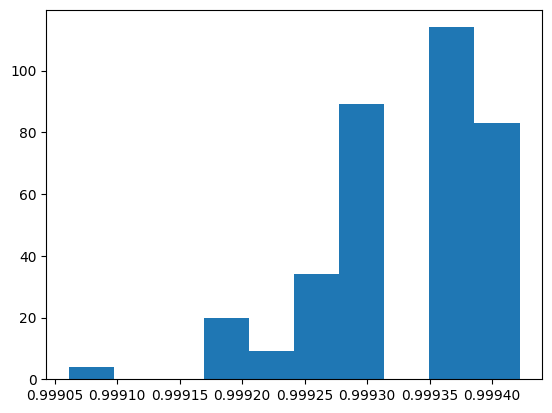

In [41]:
plt.hist(model.post_prob[:,0])

In [ ]:
with open("msl_result.pkl", "wb") as f:
    pickle.dump(model.msl_result, f)

In [47]:
0.01 * 5 /7 + 0.99 * 3 /8

0.3783928571428571

In [45]:
0.5 * 3 /7 + 0.5 * 6 /8

0.5892857142857143